분류 성능비교
==

다루는 내용
--
- 분류 알고리즘 비교
- 리지 규제, 라쏘 규제
- 교차검증
- 정적 성능평가 Confusion matrix  
- 동적 성능평가 ROC

데이터
--
- 포도주 품질 분류 https://goo.gl/Gyc8K7



모듈 불러오기
--

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
!curl -L https://goo.gl/Gyc8K7 -o wine.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   98k  100   98k    0     0   150k      0 --:--:-- --:--:-- --:--:--  150k


데이터 읽기 (포도주 품질 평가)
--

In [3]:
wine = pd.read_csv('wine.csv')
print(wine.shape)
wine.head(5)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


- fixed acidity - 결합 산도 
- volatile acidity - 휘발성 산도 
- citric acid - 시트르산 
- residual sugar - 잔류 설탕 
- chlorides	 - 염화물 
- free sulfur dioxide - 자유 이산화황 
- total sulfur dioxide - 총 이산화황 
- density - 밀도 
- pH - pH 
- sulphates - 황산염 
- alcohol - 알코올 
- quality - 품질 (0 ~ 10 점)

In [4]:
wine.info() # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## 데이터 전처리 (레이블 만들기)

In [6]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [7]:
# 품질이 좋고 나쁜 것을 나누는 기준 설정
# 6.5를 기준으로 bad(0) good(1)으로 나눈다 (임의로 나눈 것임)
my_bins = (2.5, 6.5, 8.5)
groups = [0, 1]
wine['qual'] = pd.cut(wine['quality'], bins = my_bins, labels = groups) 

wine['qual'].value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [8]:
X = wine.drop(['quality', 'qual'], axis = 1) 
y = wine['qual'] 

y.value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [9]:
X[:3]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8


표준 스케일링
--

전체 자료의 분포를 평균 0, 분산 1이 되도록 만든다.  
X에는 수치 데이터만 들어야 한다.  
테스트 데이터도 같이 스케일링하는 것을 잊지 않는다

In [0]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [11]:
X[:3]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711]])

In [12]:
# 데이터를 랜덤하게 섞은 후 80%를 훈련데이터로 사용
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train.shape, y_train.shape
# X_test.shape, y_test.shape

((1279, 11), (1279,))

## 선형 모델(확률적 경사 하강법 사용)

In [14]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd.score(X_test,y_test)

0.834375

결정 트리 (Decesion Tree)
--

In [15]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.865625

## 랜덤 포래스트 (Random Forest Classifier)

In [16]:
rfc = RandomForestClassifier(n_estimators=300) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.91875

## Support Vector Classifier (SVC)

In [17]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

0.88125

Logistic Regression
--

In [18]:
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test,y_test)

0.86875

## Cross validation(교차 검증)

In [19]:
# estimator = 모델, cv는 분할 테스트 숫자
rfc_eval = cross_val_score(rfc, X = X, y = y, cv = 5)  
rfc_eval  # 5번의 교차 검증 결과를 보여준다

array([0.875     , 0.853125  , 0.88125   , 0.865625  , 0.88401254])

In [20]:
rfc_eval.mean()

0.8718025078369905

##  정적 평가, 혼돈 매트릭스 (confusion_matrix)

In [21]:
y_pred = sgd.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[239,  30],
       [ 23,  28]])

아래는 모델이 올바르게 예측했는지를 평가하기 위한 값들이다

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       269
           1       0.48      0.55      0.51        51

    accuracy                           0.83       320
   macro avg       0.70      0.72      0.71       320
weighted avg       0.84      0.83      0.84       320



- Precision  = 모델이 옳다고 한 것이 실제로 옳은 비율     TP / ( TP + FP ) 
- Recall =  실제 정답인 것들 중, 모델이 정답이라고 예측한 것    TP / TP+FN
- f1-score = Precision과 Recall의 조화평균  (2 x  Precision x Recall ) /  (Precision + Recall)
- support는 이 모델에서 응답한 샘플의 수이다

Score (맞다고 생각하는 점수)
--

In [0]:
y_score = sgd.decision_function(X_test)

In [24]:
y_score

array([ 3.71865495e+00, -2.42425666e+00, -2.83694464e+00, -5.11774300e-01,
       -2.59982976e+00, -5.11664857e+00,  2.42442868e+00, -6.37637279e+00,
       -5.13622165e+00, -3.57381221e+00, -7.13685141e+00, -1.16131652e-01,
       -6.57815880e+00, -7.29789067e+00, -5.87446868e+00, -7.09263237e+00,
       -6.75127919e+00,  2.11489703e+00, -8.23134588e-01, -2.12615321e+00,
       -5.69621681e+00,  3.99553554e-01, -2.75156933e+00,  2.24517704e+00,
       -5.57491933e+00,  2.08589616e+00, -4.19901781e+00, -4.69927655e+00,
       -3.97926377e+00,  4.38441653e+00, -1.22309523e+00,  3.25361116e-01,
        2.44077830e+00,  1.30702693e+00,  7.48605471e-01, -7.57186914e+00,
       -3.74016565e-01, -5.09438067e+00, -2.23867089e+00, -6.29055958e+00,
       -5.80556638e+00, -7.34711310e+00, -6.36234375e+00, -8.32356303e+00,
        1.02691820e+00,  1.23313390e-01, -2.16555640e+00, -4.67085877e+00,
       -1.97484155e+00, -5.27600832e+00, -2.25980037e+00, -6.68492309e-01,
       -5.13934936e+00,  

랭킹 (순서를 평가)
--

In [25]:
result = pd.DataFrame(list(zip(y_score, y_pred, y_test)), 
                      columns=['score', 'predict', 'real'])
result['correct'] = (result.predict == result.real)
result.head()

,score,predict,real,correct
0,3.718655,1,0,False
1,-2.424257,0,0,True
2,-2.836945,0,0,True
3,-0.511774,0,0,True
4,-2.599830,0,0,True


ROC로 성능 평가 (맞춘 순서를 평가)
--

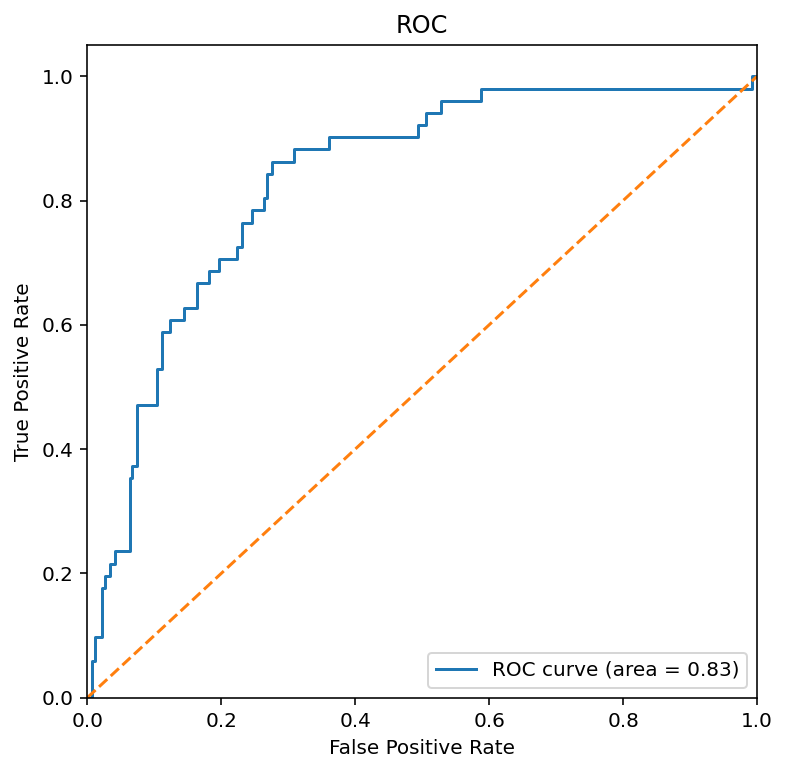

In [26]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")